## Preparation

SleepInc has provided us with an anonymized dataset of sleep and lifestyle metrics for 374 individuals. This dataset contains average values for each person calculated over the past six months.

The dataset includes 13 columns covering sleep duration, quality, disorders, exercise, stress, diet, demographics, and other factors related to sleep health. 

| Column | Description |
|---------|----------------------------------------|  
| `Person ID` | An identifier for each individual. |
| `Gender` | The gender of the person (Male/Female). |  
| `Age` | The age of the person in years. |
| `Occupation` | The occupation or profession of the person. |
| `Sleep Duration (hours)` | The average number of hours the person sleeps per day. |
| `Quality of Sleep (scale: 1-10)` | A subjective rating of the quality of sleep, ranging from 1 to 10. |
| `Physical Activity Level (minutes/day)` | The average number of minutes the person engages in physical activity daily. |  
| `Stress Level (scale: 1-10)` | A subjective rating of the stress level experienced by the person, ranging from 1 to 10. |
| `BMI Category` | The BMI category of the person (e.g., Underweight, Normal, Overweight). |
| `Blood Pressure (systolic/diastolic)` | The average blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. |
| `Heart Rate (bpm)` | The average resting heart rate of the person in beats per minute. |
| `Daily Steps` | The average number of steps the person takes per day. |
| `Sleep Disorder` | The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea). |


# Cleaning the data set

The data needs the following preparation: some types need to be fixed, we introduce categorical types where appropriate. 
The BMI categories needed simple cleaning: one category had two different names. 
We renamed the columns such that they are short and without whitespaces.
We did not need to deal with null values, but discovered that there were numerous duplicates (details below), that we eliminated. This massively reduced the size of the data set.

We split the column for blood pressure into two seperate values, and calculated a derived third value, the so called "pulse pressure". In recent years, it has gained a lot of attention in medicine. Pulse pressure allows to predict heart diseases.

Doing a first exploratory analysis, we quickly discover that our data set lacks representativity. It does not stem from a clinical study, but is just a collection of data from an app. We thus do not try to derive general insights, but rather, we will try to connect the information from individual people in the data set to some key insights reported on Wikipedia about heart diseases.

In [1]:
import pandas as pd
import numpy as np  
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

raw_data = pd.read_csv('sleep_health_data.csv')

raw_data.Gender = raw_data.Gender.astype("category")

Column occupation: here, I'm merging "Salesperson" and "Sales Representative".
Later, but only after having eliminated duplicates, I'll collapse the three jobs with the fewest individuals into an artificial job category "Other".

In [2]:
# deal with column occupation later 
print("Occupation frequencies before cleaning")
print(raw_data.Occupation.value_counts())
print("Salesperson (32) and Sales Representative (2) seem to be the same")
print("Make them the same!")
raw_data["Occupation"][raw_data["Occupation"]=="Sales Representative"] = "Salesperson"

print("Occupation frequencies after cleaning")
print(raw_data.Occupation.value_counts())
print("We will collapse these very small groups into one later, after removing duplicates")

Occupation frequencies before cleaning
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: Occupation, dtype: int64
Salesperson (32) and Sales Representative (2) seem to be the same
Make them the same!
Occupation frequencies after cleaning
Nurse                73
Doctor               71
Engineer             63
Lawyer               47
Teacher              40
Accountant           37
Salesperson          34
Software Engineer     4
Scientist             4
Manager               1
Name: Occupation, dtype: int64
We will collapse these very small groups into one later, after removing duplicates


Checking the remaining columns.
BMI category: does not contained 'underweight', but 'obese'. Because there's an inherent order, we save the BMI information as an ordered categorical data type.
The sleep disorder column is as expected.

In [3]:
print("Checking column: quality of sleep")
print(raw_data["Quality of Sleep"].value_counts())
# only 4-9 used

print("Checking column: BMI category")
print(raw_data["BMI Category"].value_counts())
print("should be: (e.g., Underweight, Normal, Overweight).")
print("does not appear: Underweight, but: Obese")
# 2 variants for normal: unified
print("These are not the same as expected (as written in the description)")
print("Two alternative spellings for the normal category: need to make them the same")
raw_data["BMI Category"][raw_data["BMI Category"]=="Normal Weight"] = "Normal"
bmi_type = CategoricalDtype(categories=["Normal", "Overweight", "Obese"], ordered=True)
raw_data["BMI Category"]=raw_data["BMI Category"].astype(bmi_type)
print(raw_data["BMI Category"].value_counts())

print("Checking column: sleep disorder")
print(raw_data["Sleep Disorder"].value_counts())
disorder_type = CategoricalDtype(categories=["None", "Insomnia", "Sleep Apnea"], ordered=True)
raw_data["Sleep Disorder"]=raw_data["Sleep Disorder"].astype(disorder_type)

Checking column: quality of sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: Quality of Sleep, dtype: int64
Checking column: BMI category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: BMI Category, dtype: int64
should be: (e.g., Underweight, Normal, Overweight).
does not appear: Underweight, but: Obese
These are not the same as expected (as written in the description)
Two alternative spellings for the normal category: need to make them the same
Normal        216
Overweight    148
Obese          10
Name: BMI Category, dtype: int64
Checking column: sleep disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: Sleep Disorder, dtype: int64


I renamed the columns because I thought this would facilitate my work. 
In particular for SQL queries, it's more comfortable to respect naming convention, like: no white spaces.
However, in the end, it's a lot of work to have to re adjust the axis labels for all plots... So, the lesson learned is, don't rename the column if the labels are as you want to see them (as axis labels) on your plots.

In [4]:
raw_data.rename(columns={"Sleep Duration":"sleep_hrs",
                         "Quality of Sleep":"qos",
                         "Physical Activity Level":"activity_min",
                         "Stress Level":"stress",
                         "Daily Steps":"steps_day",
                         "Sleep Disorder":"disorder",
                         "BMI Category":"bmi",
                         "Heart Rate":"bpm",
                        "Blood Pressure":"blood_pre",
                        "Person ID":"person_id",
                        "Gender":"gender",
                        "Occupation":"occ",
                        "Age":"age"},inplace=True)
print("Columns and their types after cleaning")
print(raw_data.dtypes)

raw_data.describe()

Columns and their types after cleaning
person_id          int64
gender          category
age                int64
occ               object
sleep_hrs        float64
qos                int64
activity_min       int64
stress             int64
bmi             category
blood_pre         object
bpm                int64
steps_day          int64
disorder        category
dtype: object


,person_id,age,sleep_hrs,qos,activity_min,stress,bpm,steps_day
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


Null values are not an issue in this data set.

In [5]:
print(raw_data.isna().sum())

person_id       0
gender          0
age             0
occ             0
sleep_hrs       0
qos             0
activity_min    0
stress          0
bmi             0
blood_pre       0
bpm             0
steps_day       0
disorder        0
dtype: int64


## Duplicates
A significant number of lines are full duplicates of another line, 
the only difference between them being the "person_id" column. 
This column  however might well have been generated automatically upon insertion. The values just go from 0 onward.

It is really suspicious to sometimes find up to 13 repetitions of the same line!

Below, take a look at the result of an SQL query showing those individuals appearing more than once in the data set: a 37 year old female accountant has 12 clones in the data set, a male salesperson aged 44 appears 11 times. Three people appear 10 times each: a 50 year old female nurse, a 43 year old male salesperson, a 39 year old male lawyer.

Take a look at these "individuals" and their features: how realistic does it seem to you to see precisely the same combination multiple times? I'm wondering how or why these duplicates might have been introduced in the data set. Maybe, there can be reasons to apply sampling techniques on the data set at some time point, in an analysis. In the case of upsampling, clones would be introduced. However, this should be clearly motivated and documented.

In [6]:
SELECT count(*) AS count, gender, age, occ, sleep_hrs, qos, activity_min, stress, bmi, blood_pre, bpm, steps_day, disorder
FROM raw_data
GROUP BY gender, age, occ, sleep_hrs, qos, activity_min, stress, bmi, blood_pre, bpm, steps_day, disorder
HAVING COUNT(*) > 1
ORDER BY count DESC;

,count,gender,age,occ,sleep_hrs,qos,activity_min,stress,bmi,blood_pre,bpm,steps_day,disorder
0,13,Female,37,Accountant,7.2,8,60,4,Normal,115/75,68,7000,None
1,11,Male,44,Salesperson,6.3,6,45,7,Overweight,130/85,72,6000,Insomnia
2,10,Male,39,Lawyer,7.2,8,60,5,Normal,130/85,68,8000,None
3,10,Male,43,Salesperson,6.5,6,45,7,Overweight,130/85,72,6000,Insomnia
4,10,Female,50,Nurse,6.0,6,90,8,Overweight,140/95,75,10000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2,Female,45,Teacher,6.8,7,30,6,Overweight,135/90,65,6000,Insomnia
74,2,Male,48,Doctor,7.3,7,65,5,Obese,142/92,83,3500,Insomnia
75,2,Female,51,Nurse,6.1,6,90,8,Overweight,140/95,75,10000,Sleep Apnea
76,2,Female,52,Accountant,6.5,7,45,7,Overweight,130/85,72,6000,Insomnia


I decide to 
- delete the column person_id, and to
- drop complete duplicates.

Below are the actual lines to eliminate the duplicates. The dataset downsizes from 374 lines to 132, leaving only individuals, and removing all of their clones.

In [7]:
print("Shape including duplicates", raw_data.shape)

print("drop column person_id")
raw_data.drop(columns=["person_id"],inplace=True) 

print("drop duplicates based on all initial columns except person_id, which I dropped in the previous line")
raw_data.drop_duplicates(keep="first",inplace=True)

print("Shape now",raw_data.shape)

Shape including duplicates (374, 13)
drop column person_id
drop duplicates based on all initial columns except person_id, which I dropped in the previous line
Shape now (132, 12)


### Column Occupation revisited

The next step is to simplify the occupations: collapse jobs with <5 persons into  "Other". My reason to do that is that I remember that for some points related to hypothesis testing, a minimal group size of 5 was important. Anyways, generalising from ONE person with a specific job to ALL people with that job wouldn't seem appropriate.

I group these few individuals (3 Software Engineers, 2 Scientists and 1 Manager) into the new "Other" job category.

In [8]:
print("Collapse the minority occupations (1-4 people into OTHER)")
occ_minorities = ["Scientist","Software Engineer","Manager"]
print(raw_data.occ.value_counts())
raw_data.loc[raw_data.occ.isin(occ_minorities), "occ"] = "Other"
print(raw_data.occ.value_counts())
# note: switching to categorical type earlier introduces complications!
raw_data.occ = raw_data.occ.astype("category")

Collapse the minority occupations (1-4 people into OTHER)
Nurse                29
Doctor               24
Engineer             22
Teacher              15
Lawyer               15
Accountant           11
Salesperson          10
Software Engineer     3
Scientist             2
Manager               1
Name: occ, dtype: int64
Nurse          29
Doctor         24
Engineer       22
Teacher        15
Lawyer         15
Accountant     11
Salesperson    10
Other           6
Name: occ, dtype: int64


## Four new columns for blood pressure

Based on the initial column 'blood_pre', containing a string, we did three things.

1. We extract the systolic and diastolic pressure contained in the initial column, and store them as separate columns.

2. Based on these two values, we classify the blood pressure: optimal, normal, high normal, hypertension grade 1,  isolated systolic hypertension (systolic > 140, diastolic < 90). Hypertension, a major risk factor for heart diseases and stroke, is known to be worsened by sleep apea. The below image from Wikipedia summarizes the blood pressure classes according to the classification of  the European Society of Cardiology (ESC) and European Society of Hypertension (ESH), because it is the one presentend in the Wikipedia article on blood pressure.

[Wikipedia: blood pressure](https://en.wikipedia.org/wiki/Blood_pressure)

![Blood tension](tension.jpeg)

3. Finally, we also calculate the less know "pulse pressure", which is the difference between systolic and diastolic pressure. When its value exceeds 50, it is an important warning sign for heart diseases. Beyond the age of 40, "pulse pressure rises quite markedly". People with problematic pulse pressure fall into specific blood pressure classes, shown in the above image as isolated systolic hypertension, of which there are several sub categories (grades 1 to 3).


[Wikipedia: pulse pressure](https://en.wikipedia.org/wiki/Pulse_pressure)

In [9]:
# split blood pressure into two columns (systolic/diastolic)
raw_data[['systolic', 'diastolic']] = raw_data['blood_pre'].str.split(pat='/', n=1, expand=True)
# turn from string into integers
raw_data['systolic'] = raw_data['systolic'].astype('int')
raw_data['diastolic'] = raw_data['diastolic'].astype('int')

# create pulse_pressure
raw_data['pulse_pressure']=raw_data['systolic'] - raw_data['diastolic']

# add classification of blood pressure according to table from wikipedia
# https://en.wikipedia.org/wiki/Blood_pressure

def blood_pressure_category(r):
    c = 'unknown'
    if (r['systolic'] < 120) and (r['diastolic'] < 80):
        c = 'optimal'
    elif (120 <= r['systolic'] <= 129) or (80 <= r['diastolic'] <= 84):
    # chose OR because with AND, there were no results
        c = 'normal'
    elif (130 <= r['systolic'] <= 139) or (85 <= r['diastolic'] <= 89):
        c = 'high_normal'
    elif (140 <= r['systolic'] <= 159) and (90 <= r['diastolic'] <= 99):
        c = 'hyper 1'
    elif (r['systolic'] >= 140 ) and (r['diastolic'] < 90):
        c= "isolated systolic hypertension"
    return c

raw_data['pressure_cat'] = raw_data.apply(lambda r: blood_pressure_category(r), axis=1)
pressure_type = CategoricalDtype(categories=["optimal","normal","high_normal","hyper 1", "isolated systolic hypertension"], ordered=True)
raw_data['pressure_cat']=raw_data['pressure_cat'].astype(pressure_type)
raw_data.drop(columns=["blood_pre"],inplace=True)

# the folowing line allows to delete unused categories, 
raw_data.pressure_cat.cat.remove_unused_categories(inplace=True)


# the next two are used for some of the later plots
stat2 = pd.DataFrame(raw_data[["pressure_cat", "disorder"]].value_counts())
stat2.reset_index(inplace=True)
stat2.columns = ["pressure_cat", "disorder", "count"]

stat3 = pd.DataFrame(raw_data[["bmi", "disorder"]].value_counts())
stat3.reset_index(inplace=True)
stat3.columns = ["bmi", "disorder", "count"]


![blood-pressure-readings-chart-English](blood-pressure-readings-chart-English.jpg)


Here are the 10 first lines of the data set after cleaning and wrangling. The columns related to blood pressure are 
- systolic
- diastolic
- pulse_pressure
- pressure_category.

In [17]:
raw_data.head(10)

,gender,age,occ,sleep_hrs,qos,activity_min,stress,bmi,bpm,steps_day,disorder,systolic,diastolic,pulse_pressure,pressure_cat
0,Male,27,Other,6.1,6,42,6,Overweight,77,4200,None,126,83,43,normal
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80,45,normal
3,Male,28,Salesperson,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,50,hyper 1
5,Male,28,Other,5.9,4,30,8,Obese,85,3000,Insomnia,140,90,50,hyper 1
6,Male,29,Teacher,6.3,6,40,7,Obese,82,3500,Insomnia,140,90,50,hyper 1
7,Male,29,Doctor,7.8,7,75,6,Normal,70,8000,None,120,80,40,normal
10,Male,29,Doctor,6.1,6,30,8,Normal,70,8000,None,120,80,40,normal
13,Male,29,Doctor,6.0,6,30,8,Normal,70,8000,None,120,80,40,normal
16,Female,29,Nurse,6.5,5,40,7,Normal,80,4000,Sleep Apnea,132,87,45,high_normal
17,Male,29,Doctor,6.0,6,30,8,Normal,70,8000,Sleep Apnea,120,80,40,normal


# Getting to know the data set

## Who are the people using the app?

Let's recall what this data is, and isn't. It's data from users of a sleep tracking app, not more and not less. There's no claim of it being balanced or representative in any way. 

A. For instance, the females are on average 50, the males under 40 (see below). The oldest male is 50 and the oldest female 60.

B. Our female participants sleep marginally less than the males, on average - but this is just an average. 

C. Despite of sleeping less, our female participants are on average happier with their sleeping quality than the males. This is a paradoxon: as we'll later see, our participants generally think that more sleep = better sleep.

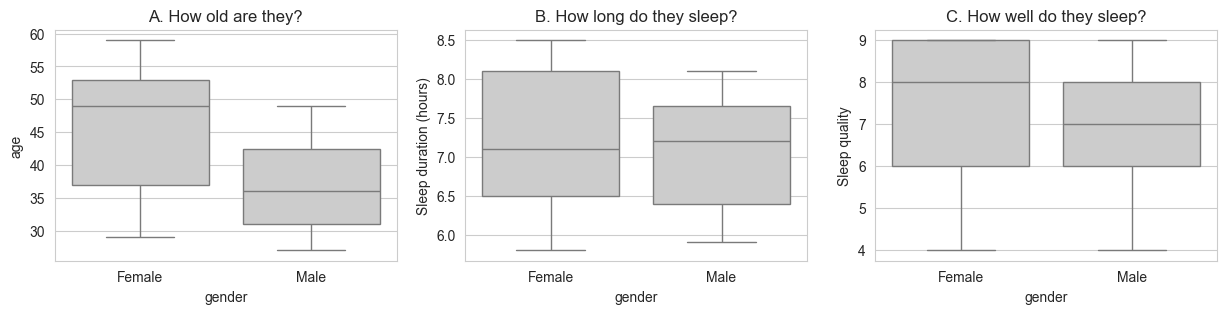

In [10]:
fig,axs=plt.subplots(1,3,figsize=(15,3))
sns.boxplot(data=raw_data,y="age",x="gender",ax=axs[0],color="0.8").set_title("A. How old are they?")

sns.boxplot(data=raw_data,y="sleep_hrs",x="gender",ax=axs[1],color="0.8").set_title("B. How long do they sleep?")
axs[1].set(ylabel="Sleep duration (hours)")

sns.boxplot(data=raw_data,y="qos",x="gender",ax=axs[2],color="0.8").set_title("C. How well do they sleep?")
axs[2].set(ylabel="Sleep quality")

plt.show()

Our participants'most frequent occupations are nurse, medical doctor, and engineers. Both may indicate who's interested by such an app, by profession or technical curiosity. 

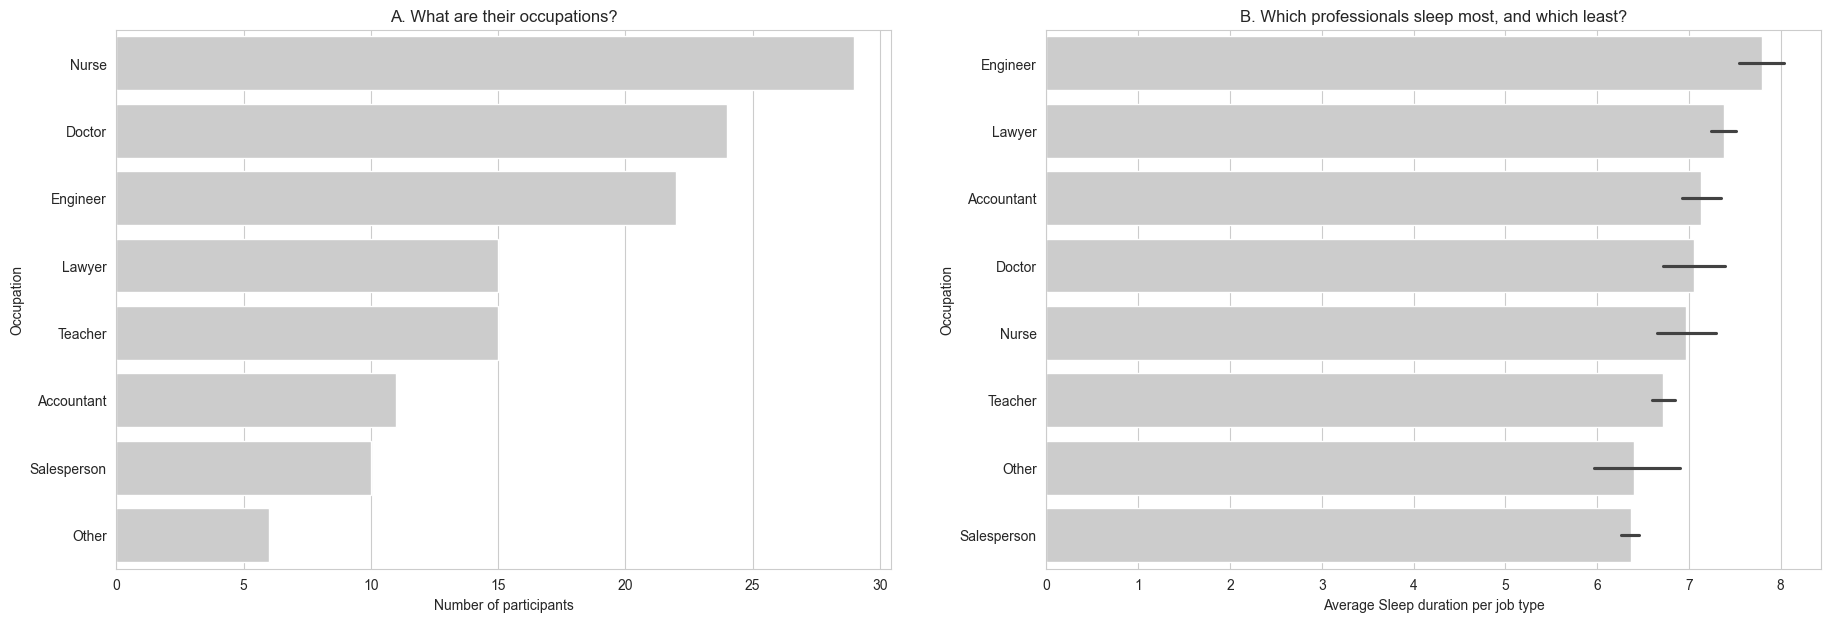

In [11]:
fig,axs=plt.subplots(1,2,figsize=(22,7))

ranking1 = raw_data.groupby("occ",as_index=False).size()
ranking1.sort_values("size",ascending=False, inplace=True)
sns.barplot(data=ranking1,y="occ",
            x="size",
           order=ranking1.occ.values,
            ax=axs[0],
            color="0.8"
           )
axs[0].set(
        title="A. What are their occupations?",
        xlabel="Number of participants",
        ylabel="Occupation")
#---------
ranking = raw_data.groupby("occ").agg({"sleep_hrs":"mean"}).sort_values("sleep_hrs",ascending=False)
sns.barplot(data=raw_data,y="occ",
            x="sleep_hrs",
            order=ranking.index.values,
            ax=axs[1],
           color="0.8")
axs[1].set(xlabel="Average Sleep duration per job type",
          ylabel="Occupation",
          title="B. Which professionals sleep most, and which least?")
plt.show()


## Impact of physical activity on sleep duration and quality

We check how the duration of physical activity per day impacts on both the number of hours slept (A), and the individual perception of the quality of sleep (B). In both cases, a straight line drawn through the individual points has a clear upward slope. 
Differences between the individuals are indicated by the wide bands around the straight lines. 

That lets us suppose that more excercice may improve sleep in general.

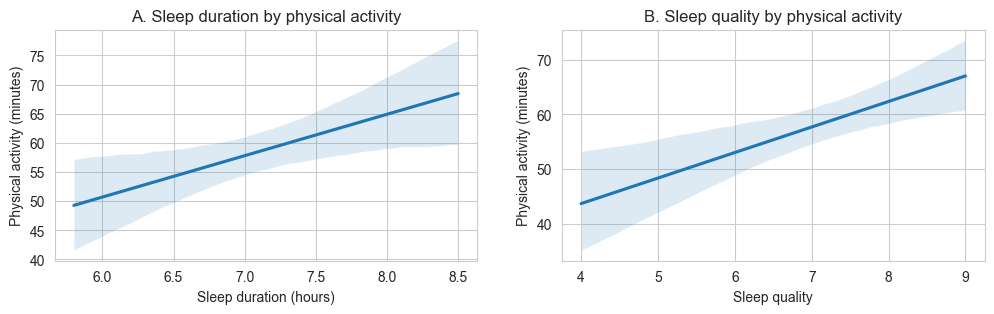

In [12]:
fig,axs=plt.subplots(1,2,figsize=(12,3))

sns.regplot(data=raw_data,y="activity_min",x="sleep_hrs",scatter=False,
            ax=axs[0]).set_title("A. Sleep duration by physical activity")
axs[0].set(xlabel="Sleep duration (hours)",ylabel="Physical activity (minutes)")

sns.regplot(data=raw_data,y="activity_min",x="qos",scatter=False,ax=axs[1]).set_title("B. Sleep quality by physical activity")
axs[1].set(xlabel="Sleep quality",ylabel="Physical activity (minutes)")
plt.show()

### Sleeping disorders: frequency and sleep duration

A. About half of our participants sleep normally. About one out of 4 suffers from insomnia (that means, they sleep less than they would like to), and another one out of 4 from sleep apnea.

B. Normal sleepers enjoy between 6 and 8.5 hours of sleep per night, with an average near 7.5 hours. People suffering from insomnia sleep on average about an hour less. Sleep apnea is often not noticed by the person suffering from it, and the range of hours slept extends from under 5 to over 8. We highlighted sleep apnea in color here, because it is indeed a major health risk. We will try to learn as much about it here, as we can. 

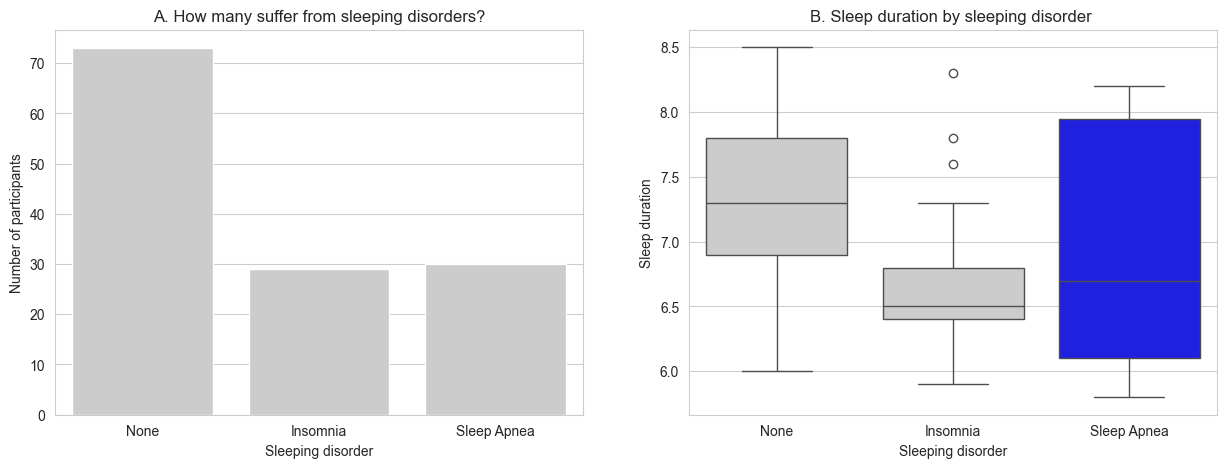

In [13]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

ax=sns.countplot(data=raw_data, x="disorder", #order=ranking.index,
                 color="0.8",ax=axs[0]).set_title("A. How many suffer from sleeping disorders?")
axs[0].set_xlabel("Sleeping disorder")
axs[0].set_ylabel("Number of participants")

#--------
my_pal = {d: "b" if d == "Sleep Apnea" else ".8" for d in raw_data.disorder}
sns.boxplot(data=raw_data,x="disorder",y="sleep_hrs",palette=my_pal,ax=axs[1]).set_title("B. Sleep duration by sleeping disorder ")
axs[1].set_ylabel("Sleep duration")
axs[1].set_xlabel("Sleeping disorder")

plt.show()

In our data set, we observe the following correlations:
### A: With more stress, the heart beats faster (0.6).
### B: When the heart beats faster, the sleeping quality degrades (-0.7).
### C: When the heart beats faster, the person sleeps less (-0.5)
### D: When the stress increases,  the sleep becomes less (- 0.8).
### E: More sleep is perceived as better sleeping quality (0.9)

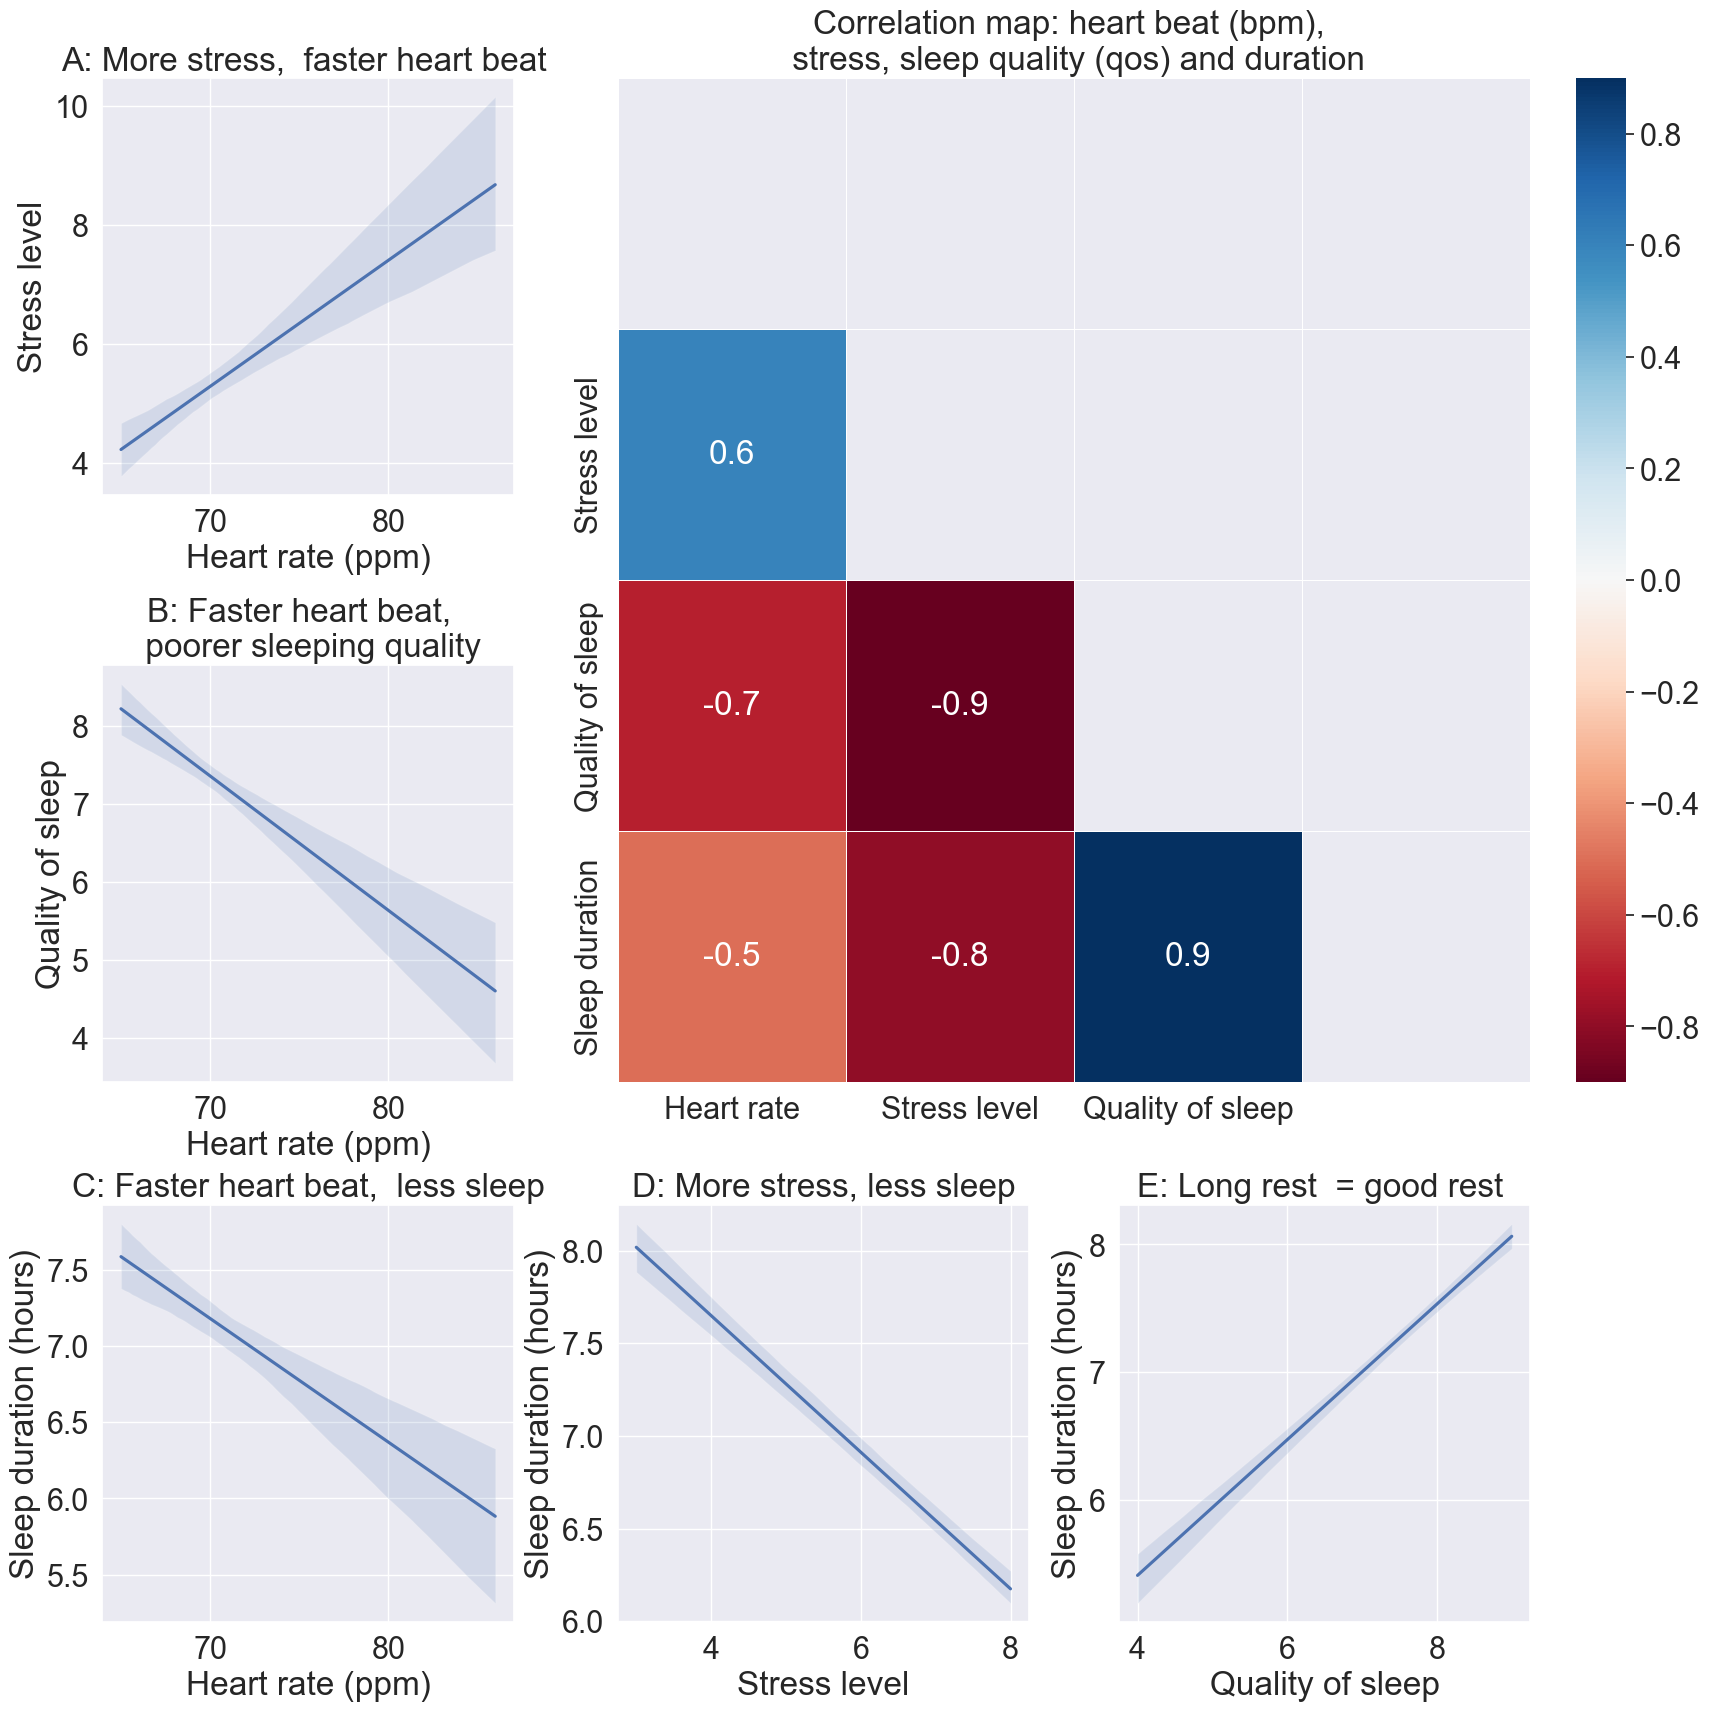

In [14]:
sns.set(font_scale=2)
corrmap=raw_data[["bpm","stress","qos","sleep_hrs"]].corr()
mask=np.triu(np.ones_like(corrmap,dtype=bool))
fig,axs=plt.subplot_mosaic([['1','map','map'],['2','map','map'],['3','4','5']],
                          figsize=(17,17),layout="constrained")

g=sns.heatmap(round(corrmap, 1), 
            mask=mask, annot=True,
           xticklabels=["Heart rate","Stress level","Quality of sleep",""],
            yticklabels=["","Stress level","Quality of sleep","Sleep duration"],
            ax=axs['map'],
              cbar=True,linewidth=.5,
            cmap='RdBu'
           ).set_title("Correlation map: heart beat (bpm), \n stress, sleep quality (qos) and duration")

#-------------- 
sns.regplot(data=raw_data,y="stress",x="bpm",scatter=False,ax=axs['1']).set_title("A: More stress,  faster heart beat ")
axs['1'].set(ylabel="Stress level")
axs['1'].set(xlabel="Heart rate (ppm)")

sns.regplot(data=raw_data,y="qos",x="bpm",scatter=False,ax=axs['2']).set_title("B: Faster heart beat,  \n poorer sleeping quality")
axs['2'].set(ylabel="Quality of sleep")
axs['2'].set(xlabel="Heart rate (ppm)")


sns.regplot(data=raw_data,y="sleep_hrs",x="bpm",scatter=False,ax=axs['3']).set_title("C: Faster heart beat,  less sleep")
axs['3'].set(ylabel="Sleep duration (hours)")
axs['3'].set(xlabel="Heart rate (ppm)")


sns.regplot(data=raw_data,x="stress",y="sleep_hrs",scatter=False,ax=axs['4']).set_title("D: More stress, less sleep")
axs['4'].set(xlabel="Stress level")
axs['4'].set(ylabel="Sleep duration (hours)")

sns.regplot(data=raw_data,x="qos",y="sleep_hrs",scatter=False,ax=axs['5']).set_title("E: Long rest  = good rest ")
axs['5'].set(xlabel="Quality of sleep")
axs['5'].set(ylabel="Sleep duration (hours)")

plt.show()

sns.set(font_scale=1)

### A. The higher the BMI, the higher the blood pressure. 

### B. The higher the blood pressure, the more sleeping disorders. Hypertension and sleep apnea is a frequent and dangerous combination.
For optimal and normal blood pressure, sleeping disorders are very uncommon.

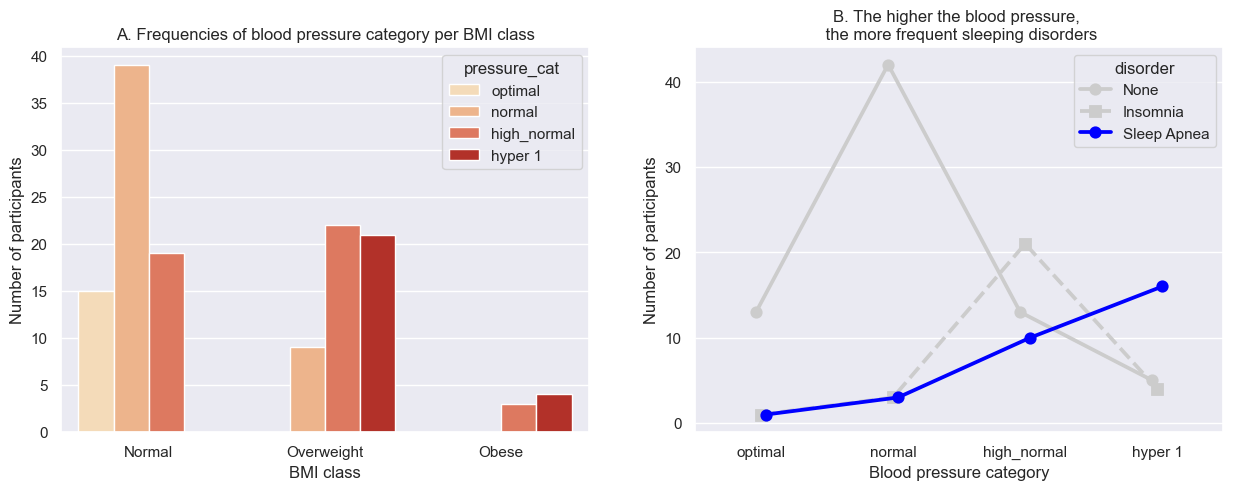

In [23]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=raw_data,
                 x="bmi",
                 hue="pressure_cat", 
                 palette="OrRd",
             ax=axs[0])
axs[0].set(title="A. Frequencies of blood pressure category per BMI class")
axs[0].set(ylabel="Number of participants",xlabel="BMI class")

sns.pointplot(data=stat2, x="pressure_cat", y="count", hue="disorder", 
                   palette=["0.8", "0.8", "blue"],
                   linestyles=["-", "--","-"],
                   markers=["o", "s","o"],
                   dodge=True,ax=axs[1]
                 ).set_title("B. The higher the blood pressure, \n the more frequent sleeping disorders")
axs[1].set_xlabel("Blood pressure category")
axs[1].set_ylabel("Number of participants")
plt.show()

### Stress and blood pressure

A person's stress level is believed to influence blood pressure.
There seems to be some thruth to it: below, we show the stress level distributions per category of blood pressure.
The tips of the violin plots move higher with increasing blood pressure.

However, there are huge individual variations: for a given category of blood pressure, stress level can vary within a certain range. These ranges widen with increasing blood pressure - the violin plots become longer. 

Note that  females may suffer from hypertension even when they report only a low level of stress in their life. 

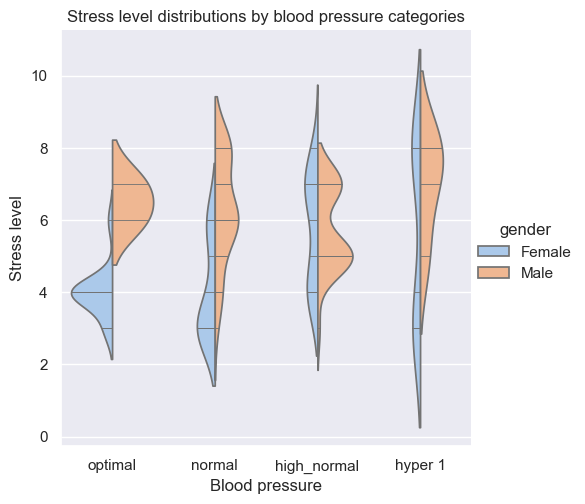

In [15]:
ax = sns.catplot(data=raw_data, 
                 y="stress", x="pressure_cat", kind="violin", 
                 inner="stick", 
                 split=True, 
                 hue="gender", palette="pastel",
                 legend_out=True
              )
ax.set_xlabels("Blood pressure") 
ax.set_ylabels("Stress level") 
plt.title("Stress level distributions by blood pressure categories")
plt.show()

What is easier to see, is that the sleep duration decreases with higher blood pressure, for both genders.

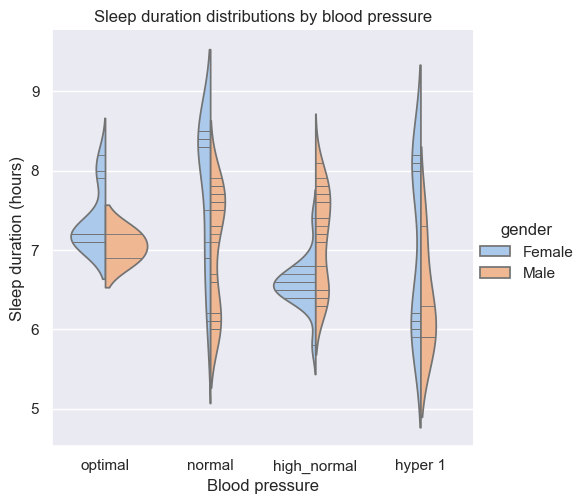

In [25]:
ax = sns.catplot(data=raw_data, 
                 y="sleep_hrs", x="pressure_cat", kind="violin", 
                 inner="stick", split=True, 
                 hue="gender", palette="pastel",
                 legend_out=True
              )
ax.set_xlabels("Blood pressure") 
ax.set_ylabels("Sleep duration (hours)") 
plt.title("Sleep duration distributions by blood pressure")
plt.show()

## Pulse pressure

A pulse pressure around 40 is considered healthy,  heart diseases become likely beyond a threshold of 50. When the value exceeds 60, it is often associated with a disease. A pulse pressure over 50 is called _isolated systolic hypertension_. This medical term means that the systolic value is very high (thus hyper), and that it is far away or isolated from the second value (diastolic).

Dotted red lines show the critical threshold of a pulse pressure of 50 in the below visualizations for our data set.

- A) The combinations of diastolic vs systolic blood pressure of our participants. Each blue dot corresponds to one participant. The blue line shows the trend of the data. The red line shows where the difference between diastolic and systolic pressure is exactly 50. No individual is within the risk zone, that is, below the red line. But several participants are exactly on the boundary to problematic pulse pressure. They will cross it in the future, if their life doesn't change.
- B) Here, we show the number of participants with specific pulse pressure values, and the critical threshold of 50. The column widths is 2.5. 
- C) Pulse pressure increases with blood pressure in general. This is already shown by the blue line in sub figure A. Here, we consider blood pressure categories rather than individual values. Per category, we show the middle value of pulse pressure as a blue dot, and the range as a vertical blue line through this dot. People with hypertension can exceed the threshold for high risk of heart diseases: as we see, the pulse pressure range for grade 1 hypertension touches the red line.

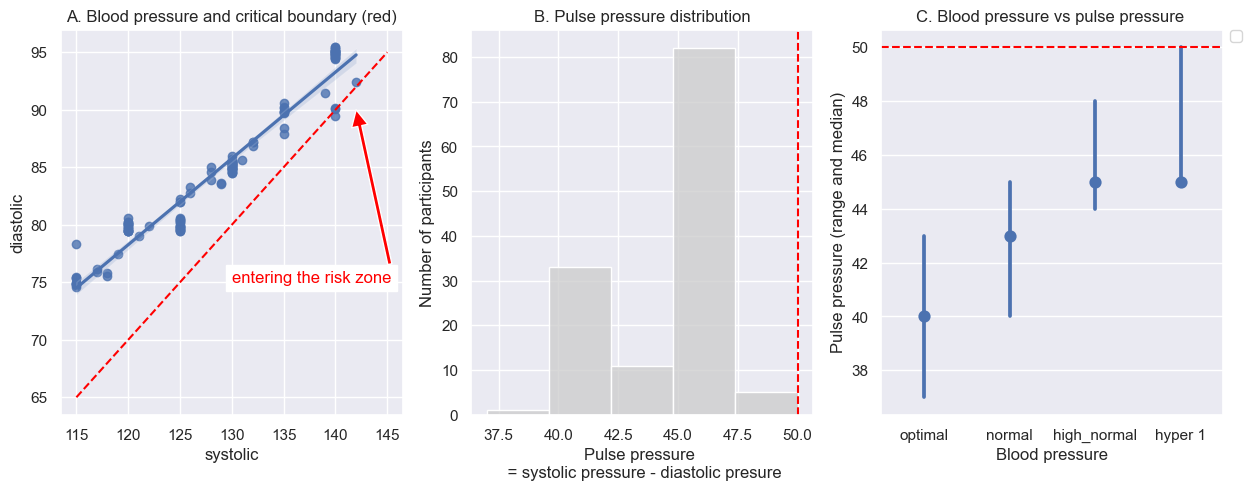

In [26]:
# draw a line representing the "boundary" for stroke pressure = 50
# 115/65,  120/70, 125/75, ...

dia = pd.Series(np.arange(65,96,2.5))
sys = pd.Series(np.arange(115,146,2.5))

fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.regplot(data=raw_data,x="systolic",y="diastolic",y_jitter=.6,ax=axs[0]
           ).set_title("A. Blood pressure and critical boundary (red)")
sns.lineplot(x=sys,y=dia,ax=axs[0],dashes=True,color="red",linestyle="--")
axs[0].annotate("entering the risk zone",
                xy=(142,90),
                xytext=(130,75),
                arrowprops={'facecolor':"red",'width':3},
                backgroundcolor='white',
                c="red"
               )                                                                                      
#-------------
sns.set_style("white")

sns.histplot(data=raw_data,x="pulse_pressure",color="0.8",ax=axs[1],binwidth=2.5).set_title("B. Pulse pressure distribution")
#axs[1].axvline(40,linestyle="--",label="optimal pulse pressure")
axs[1].axvline(50,linestyle="--",color="red")
axs[1].set(xlabel="Pulse pressure \n = systolic pressure - diastolic presure",
      ylabel="Number of participants",)
#-----------

sns.pointplot(data=raw_data,#hue="disorder",
              ax=axs[2],
                 y="pulse_pressure",x="pressure_cat",
                 join=False,
                 dodge=True,
                 estimator="median",
                 errorbar=("pi",100)).set_title("C. Blood pressure vs pulse pressure ")

axs[2].set(xlabel="Blood pressure")
axs[2].set(ylabel="Pulse pressure (range and median)")
axs[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
axs[2].axhline(50,linestyle="--",color="red")

plt.show()

In [27]:
SELECT * 
FROM raw_data
WHERE raw_data.pulse_pressure > 49

,gender,age,occ,sleep_hrs,qos,activity_min,stress,bmi,bpm,steps_day,disorder,systolic,diastolic,pulse_pressure,pressure_cat
0,Male,28,Salesperson,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,50,hyper 1
1,Male,28,Other,5.9,4,30,8,Obese,85,3000,Insomnia,140,90,50,hyper 1
2,Male,29,Teacher,6.3,6,40,7,Obese,82,3500,Insomnia,140,90,50,hyper 1
3,Male,48,Doctor,7.3,7,65,5,Obese,83,3500,Insomnia,142,92,50,hyper 1


In [28]:
SELECT *
FROM raw_data
WHERE 
	disorder = 'Sleep Apnea'
	and pressure_cat NOT IN ('hyper 1') and pulse_pressure > 45
ORDER BY bmi DESC, pressure_cat DESC, pulse_pressure DESC

,gender,age,occ,sleep_hrs,qos,activity_min,stress,bmi,bpm,steps_day,disorder,systolic,diastolic,pulse_pressure,pressure_cat
0,Male,49,Doctor,8.1,9,85,3,Obese,86,3700,Sleep Apnea,139,91,48,high_normal
1,Male,35,Lawyer,7.4,7,60,5,Obese,84,3300,Sleep Apnea,135,88,47,high_normal
2,Female,38,Lawyer,7.4,7,60,5,Obese,84,3300,Sleep Apnea,135,88,47,high_normal


In [29]:
SELECT * 
FROM raw_data
WHERE pressure_cat = 'hyper 1' and disorder = 'Sleep Apnea' and steps_day>=7000  and qos >=8;

,gender,age,occ,sleep_hrs,qos,activity_min,stress,bmi,bpm,steps_day,disorder,systolic,diastolic,pulse_pressure,pressure_cat
0,Female,57,Nurse,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
1,Female,57,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
2,Female,58,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
3,Female,59,Nurse,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
4,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
5,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95,45,hyper 1
